# Pre-Processing of Data

In [79]:
# Misc
import os
import sys
from timeit import default_timer as timer 
import datetime
now = datetime.datetime.now()

# Data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
import plotly.graph_objects as go
from scipy.optimize import curve_fit
from scipy.stats import norm,kstest
from make_plots import*

from scipy.signal import welch


# Sanity check for jupyter notebooks
print("Current working directory:", os.getcwd())

Current working directory: c:\Users\gabri\Documents\GitHub\IceClassic\sandbox\content



# [Nenana Ice Classic](https://www.nenanaakiceclassic.com/)
> The Ice Classic is Alaska's greatest guessing game! 
In Nenana during 1917 a group of engineers surveying for the Alaska Railroad bet $800 putting in their guesses when the river would break up. This fun little guessing game has turned into an incredible tradition that has now continued for over 100 years! 
Buy and turn in your $3.00 ticket between February 1st and April 5th to be involved in this long running Alaskan tradition. 

# Motivation 
We want to 
- Predict day of break up
- Predict time of break up
- Create betting strategy
- Have fun


# Loading the dataframe
The source and explanation of each column is in the txt.

In [80]:
Data=pd.read_csv('Time_series_DATA.txt',skiprows=149,index_col=0)
# Data.loc['2017-01-06', 'IceThickness [cm]'] = 88.9
# Data.loc['2017-06-01', 'IceThickness [cm]'] = np.nan
# Data=pd.read_csv('https://github.com/iceclassic/sandbox/blob/main/content/Time_series_DATA.txt?raw=true',index_col=0,skiprows=149)

# Inspecting Data

In [81]:
Data.index=pd.to_datetime(Data.index)
Data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41351 entries, 1854-01-01 to 2024-02-06
Data columns (total 26 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Regional: Air temperature [C]                      38563 non-null  float64
 1   Days since start of year                           38563 non-null  float64
 2   Days until break up                                38563 non-null  float64
 3   Predicted ice thickness [m]                        38563 non-null  float64
 4   Noisy predicted ice thickness [m]                  25762 non-null  float64
 5   Nenana: Rainfall [mm]                              29547 non-null  float64
 6   Nenana: Snowfall [mm]                              19945 non-null  float64
 7   Nenana: Snow depth [mm]                            15984 non-null  float64
 8   Nenana: Mean water temperature [C]                 2418 non-null   fl

# Visualizing the dataframe
The data is a dataframe, with the index a datetime object.
I added the columns `Data['Days since start of year']`and `Data[Days until break up ]`, that can be used as  the x-axis to plot the variables in a more convenient way.

Using the command plot in columns that are *sparse* might not work, use scatter, or simply extract column, delete rows without data `Data['colname'].dropna()` and re-define index as datetime object (
`Data.index=pd.to_datetime(Data.index)`)

# Temperature Data

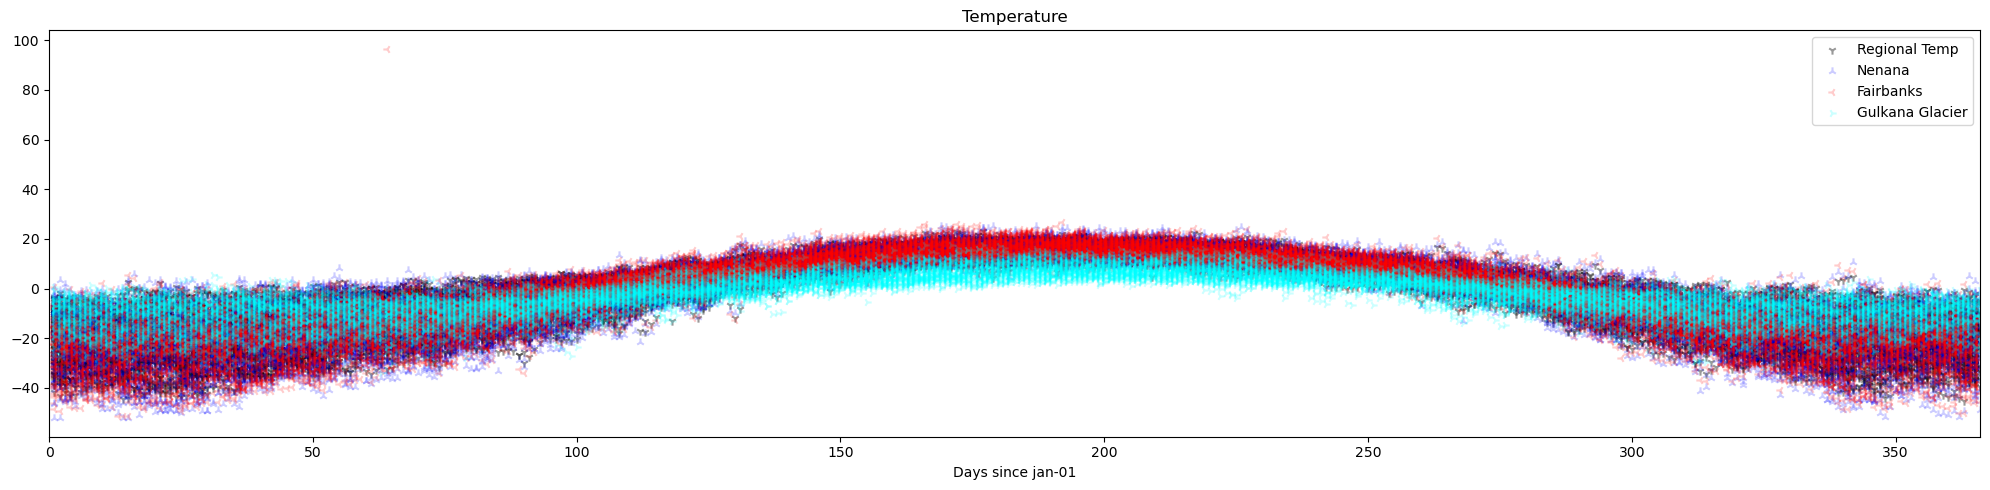

In [82]:
fig, ax1 = plt.subplots(1,1,figsize=(20,5)) 
plt.scatter(Data['Days since start of year'],Data['Regional: Air temperature [C]'],color='k',marker='1',alpha=0.4,label='Regional Temp')
plt.scatter(Data['Days since start of year'],Data['Nenana: Air temperature [C]'],color='b',marker='2',alpha=0.2,label='Nenana')
plt.scatter(Data['Days since start of year'],Data['Fairbanks: Air Temperature [C]'],color='r',marker='3',alpha=0.2,label='Fairbanks')
plt.scatter(Data['Days since start of year'],Data[' Gulkana Temperature [C]'],color='cyan',marker='4',alpha=0.2,label='Gulkana Glacier')
plt.legend()
plt.xlabel('Days since jan-01')
plt.title("Temperature")
plt.xlim([0,366])
plt.tight_layout()
plt.show()

What did we learn:
- The temperature in Nenana is very similar to the temperature in Fairbanks and  to regional measurements from  a 1$ \degree $ grid. We can assume no microclimate near the tripod, at least in terms of temperature.
- Temperature in Gulkana glaciers is different, which is obvious as it is over 1500m and 200km south-west. The direct effects on the ice near Nenana will be negligible, but it might be useful to explore the effects in the melting of the glacier (see columns 20-23 ) and discharge.
- Lets ignore Nenana and Fairbanks temperatures time series and work instead with `Regional: Air temperature [C]'`, as it has more data. 

> We could get more precision by using the temperature data from the Nenana station ( a little bit less data but still >60 years of daily observations)


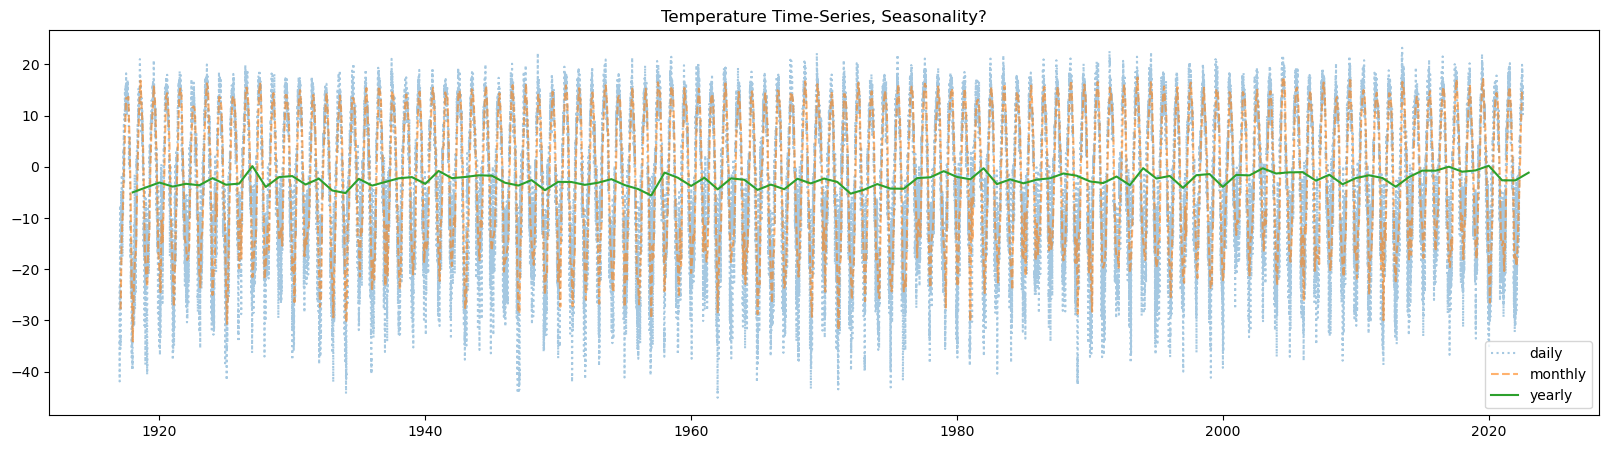

In [83]:
fig, ax1 = plt.subplots(1,1,figsize=(20,5)) 
plt.plot(Data['Regional: Air temperature [C]'],label='daily',alpha=0.4,linestyle='dotted')
plt.plot(Data['Regional: Air temperature [C]'].resample('M').mean().dropna(),label='monthly',alpha=0.6,linestyle='dashed')
plt.plot(Data['Regional: Air temperature [C]'].resample('Y').mean().dropna(),label='yearly')
plt.title('Temperature Time-Series, Seasonality?')
plt.legend()
plt.show()

What did we learn:
- At a glance, no multiyear oscillation, no relevant trend
- We assume the time-series to be stationary

> We could properly de-trend the data if we need a little bit more precision.
.


In [115]:

import os
import sys
from timeit import default_timer as timer 
import datetime
now = datetime.datetime.now()

# Data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
import plotly.graph_objects as go
from scipy.optimize import curve_fit
from scipy.stats import norm,kstest
from matplotlib.cm import ScalarMappable
from scipy.stats import pearsonr



def standard_plot(Data,Ice):
    """
    Ice: One column with the data. We assume same length as data ( if we create ice from temperature data it should match)
    Data:Data=pd.read_csv('https://github.com/iceclassic/sandbox/blob/main/content/Time_series_DATA.txt?raw=true',index_col=0,skiprows=149)

    """
    
    # HERE WE ASSUME THAT THE ICE DATA WAS PRODUCED FROM THE TEMP DATA IN THE DF SO WE DONT WORRY ABOUT DIFFERENT LENGTHS
    # Getting the df ready to plot and fit 
    filtered_data = Data.dropna(subset=['Predicted ice thickness [m]', 'IceThickness [cm]']).copy()
    years = filtered_data.index.year.unique()
    colors = plt.cm.viridis(np.linspace(0, 1, len(years)))
 
    drop_mask = Data[['Predicted ice thickness [m]', 'IceThickness [cm]']].notna().all(axis=1)

    filtered_data=Data[drop_mask]
    Ice=Ice[drop_mask]

    years = filtered_data.index.year.unique()
    colors = plt.cm.viridis(np.linspace(0, 1, len(years)))
    #==========================================================================
    filtered_data['Residuals'] = Ice * 100 - filtered_data['IceThickness [cm]']

    #
    fig, ax = plt.subplots(7, 1, figsize=(20, 35))

    plot_style={
                'Style1':{'color':'navy','alpha':0.8,'linestyle':'-'},
                'Style2':{'color':'magenta','alpha':0.8,'linestyle':'--'},
                'Cmap':{'cmap':'viridis'}}


    #----------PLOT 1----------------------------------------#

    ax[0].plot(filtered_data.index,Ice*100, **plot_style['Style1'], label='Predicted ice thickness')
    ax[0].plot(filtered_data.index,filtered_data["IceThickness [cm]"], **plot_style['Style2'], label='Measured ice thickness')
    ax[0].set_ylabel('Predicted Ice Thickness [cm]')
    ax[0].legend()
    ax[0].set_title('Predicted ice thickness')
    
    L2=np.sqrt(np.sum(filtered_data['Residuals'] ** 2))
    
    #----------PLOT 2----------------------------------------#
    sc = ax[1].scatter(filtered_data['Days until break up'],filtered_data['Regional: Air temperature [C]'], c=filtered_data.index.year,**plot_style['Cmap'],s=1)
    for i, year in enumerate(years):
        year_data = filtered_data[filtered_data.index.year == year]
        ax[1].plot(year_data['Days until break up'],year_data['Regional: Air temperature [C]'], marker=',', color=colors[i], alpha=0.8)

    cbar = plt.colorbar(sc)
    cbar.set_label('Year')

    ax[1].set_ylabel('Air temperature [C]')
    ax[1].set_xlabel('Days until break up')
    ax[1].legend()
    ax[1].set_title('Regional Air temperature, normalized to days until break up')

    n_degree = 3
    coefficients, residuals, _, _, _= np.polyfit(year_data['Days until break up'], year_data['Regional: Air temperature [C]'], n_degree,full=True)
    polynomial = np.poly1d(coefficients)
    x_fit = np.linspace(-130, 0, 120)
    y_fit = polynomial(x_fit)
    ax[1].plot(x_fit, y_fit, color='k', label=f'Polynomial Fit (degree={n_degree}, L2={np.sqrt(residuals[0]):.2f})', linestyle='--', linewidth=3)
    ax[1].legend()
    #----------PLOT 3----------------------------------------#
    sc = ax[2].scatter(filtered_data['Days until break up'], Ice * 100, c=filtered_data.index.year,**plot_style['Cmap'],s=1)
    for i, year in enumerate(years):
        year_data = filtered_data[filtered_data.index.year == year]
        year_data_ice= Ice[filtered_data.index.year == year]
        ax[2].plot(year_data['Days until break up'], year_data_ice* 100, marker=',', color=colors[i], alpha=0.8)

    cbar = plt.colorbar(sc)
    cbar.set_label('Year')

    ax[2].scatter(filtered_data['Days until break up'], filtered_data["IceThickness [cm]"], color="magenta", alpha=0.8,label='Measured ice thickness', marker='1', s=100)
    ax[2].set_ylabel('Predicted Ice Thickness [cm]')
    ax[2].set_xlabel('Days until break up')
    ax[2].legend()
    ax[2].set_title('Predicted ice thickness, normalized to days until break up')

    #----------PLOT 3----------------------------------------#
    sc = ax[3].scatter(filtered_data['Days until break up'], filtered_data['Residuals'], c=filtered_data.index.year, cmap='viridis', alpha=0.8,s=1)
    cbar = plt.colorbar(sc)
    cbar.set_label('Year')

    for i, year in enumerate(years):
        year_data = filtered_data[filtered_data.index.year == year]
        ax[3].plot(year_data['Days until break up'], year_data['Residuals'], marker='1', color=colors[i], alpha=0.8)

    # Polynomial fit
    n_degree = 1
    coefficients, residuals, _, _, _= np.polyfit(filtered_data['Days until break up'], filtered_data['Residuals'], n_degree,full=True)
    polynomial = np.poly1d(coefficients)
    x_fit = np.linspace(-130, 0, 120)
    y_fit = polynomial(x_fit)
    ax[3].plot(x_fit, y_fit, color='k', label=f'Polynomial Fit (degree={n_degree}, L2={np.sqrt(residuals[0]):.2f})', linestyle='--', linewidth=3)

    ax[3].set_ylabel('Residuals [cm]')
    ax[3].set_xlabel('Days to break up')
    ax[3].set_title('Predicted ice thickness residuals')
    ax[3].legend()
    print(f'Prediction vs measurement, polyfit(n=1) residuals, L2={np.sqrt(residuals[0]):.2f})')


    #----------PLOT 4----------------------------------------#
    for year, color in zip(filtered_data.index.year.unique(), colors):
        year_data = filtered_data[filtered_data.index.year == year]
        ax[4].hist(year_data['Residuals'], bins=15, density=True, alpha=0.5, label=f'Year {year}', color=color)
    ax[4].set_xlabel('Residuals[cm]')
    ax[4].set_ylabel('Density')
    ax[4].set_title('Distribution of residuals per year')
    ax[4].set_xlim([-70,70])


    # Create a ScalarMappable for color mapping
    sm = ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(years), vmax=max(years)))
    sm.set_array([])  # Empty array since we just want to map colors

    # Add color bar
    cbar = plt.colorbar(sm, ax=ax[4])
    cbar.set_label('Years')


    # normal fit
    aggregated_data=filtered_data['Residuals'] 
    mu, std = norm.fit(aggregated_data)
    ks_statistic, p_value = kstest(aggregated_data, 'norm', args=(mu, std))
    print("================================================================================")
    print("Aggregated predicted vs measured residuals:")
    print(f'KS Statistic:{ks_statistic:.3f}')
    print(f'P-value:{p_value:.2f}')
    print(f'N ~ (\mu={mu:.2f},\sigma={std:.2f})')
    x = np.linspace(-70,70, 140)
    p = norm.pdf(x, mu, std)
    ax[5].plot(x, p, 'k', linewidth=2)
    ax[5].hist(aggregated_data, bins='auto',density=True, alpha=0.4,color='k')
    ax[5].set_xlabel('Residuals[cm]')
    ax[5].set_ylabel('Density')
    ax[5].set_title('Distribution of aggregated residuals')
    ax[5].set_xlim([-70,70])


    #----------------------SCatter plot###

    corr, _ = pearsonr(filtered_data['Days until break up'],filtered_data["IceThickness [cm]"])
    print("================================================================================")
    print("Ice thickness vs days to break up\nPearson correlation coefficient:", corr)

############### Ice thickennes at break up ( last three data points)
    # Add  break up date line
    last=[]
    for year, color in zip(filtered_data.index.year.unique(), colors):
        year_data = filtered_data[filtered_data.index.year == year]
        path_to_break_up = filtered_data[filtered_data.index.year == year].tail(5)
        last_measurement = filtered_data[filtered_data.index.year == year].tail(1)
        last.append(last_measurement['IceThickness [cm]'])
        ax[6].plot(path_to_break_up['Days until break up'],path_to_break_up['IceThickness [cm]'], color=color,linestyle='--',alpha=0.4)
        ax[6].scatter(last_measurement['Days until break up'],last_measurement['IceThickness [cm]'], color=color)

        year_data= year_data['Days until break up'] == 0
        #ax[7].axvline(year_data['Days since start of year'], color=color, linestyle='--')
        

    # Create a ScalarMappable for color mapping
    sm = ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(years), vmax=max(years)))
    sm.set_array([])  # Empty array since we just want to map colors

    # Add color bar
    cbar = plt.colorbar(sm, ax=ax[6])
    cbar.set_label('Years')
    ax[6].set_ylabel('IceThickness [cm]')
    ax[6].set_xlabel('Days until break up')
    ax[6].set_title('Last k-IceThickness measurements(k=5)')
    print("Ice thickness before break up")
    print(last)
    print("============================================================")
    print("Mean IceThickness measurements before break up",np.mean(last))
    plt.show()

# (Predicted) Ice Thickness
We have ice thickness measurement from the last 30 years, but the frequency of the measurements  is not very good (around 15 data-points from jan-01 to break up).

We can use our temperature time-series to make a very rudimentary prediction of the ice-growth using Ashton's formula ( see detail in column description)

C:\Users\gabri\AppData\Local\Temp\ipykernel_17368\1216952458.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Residuals'] = Ice * 100 - filtered_data['IceThickness [cm]']
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Prediction vs measurement, polyfit(n=1) residuals, L2=386.81)
Aggregated predicted vs measured residuals:
KS Statistic:0.057
P-value:0.11
N ~ (\mu=0.72,\sigma=18.85)
Ice thickness vs days to break up
Pearson correlation coefficient: 0.12459312941991435
Ice thickness before break up
[1989-04-12    101.6
Name: IceThickness [cm], dtype: float64, 1990-03-30    91.44
Name: IceThickness [cm], dtype: float64, 1991-04-18    96.52
Name: IceThickness [cm], dtype: float64, 1992-04-22    119.38
Name: IceThickness [cm], dtype: float64, 1993-04-09    63.5
Name: IceThickness [cm], dtype: float64, 1994-04-22    116.84
Name: IceThickness [cm], dtype: float64, 1995-04-13    81.28
Name: IceThickness [cm], dtype: float64, 1996-04-22    105.41
Name: IceThickness [cm], dtype: float64, 1997-04-04    107.95
Name: IceThickness [cm], dtype: float64, 1998-04-03    96.52
Name: IceThickness [cm], dtype: float64, 1999-04-15    109.22
Name: IceThickness [cm], dtype: float64, 2000-04-13    91.44
Name: IceThickness [c

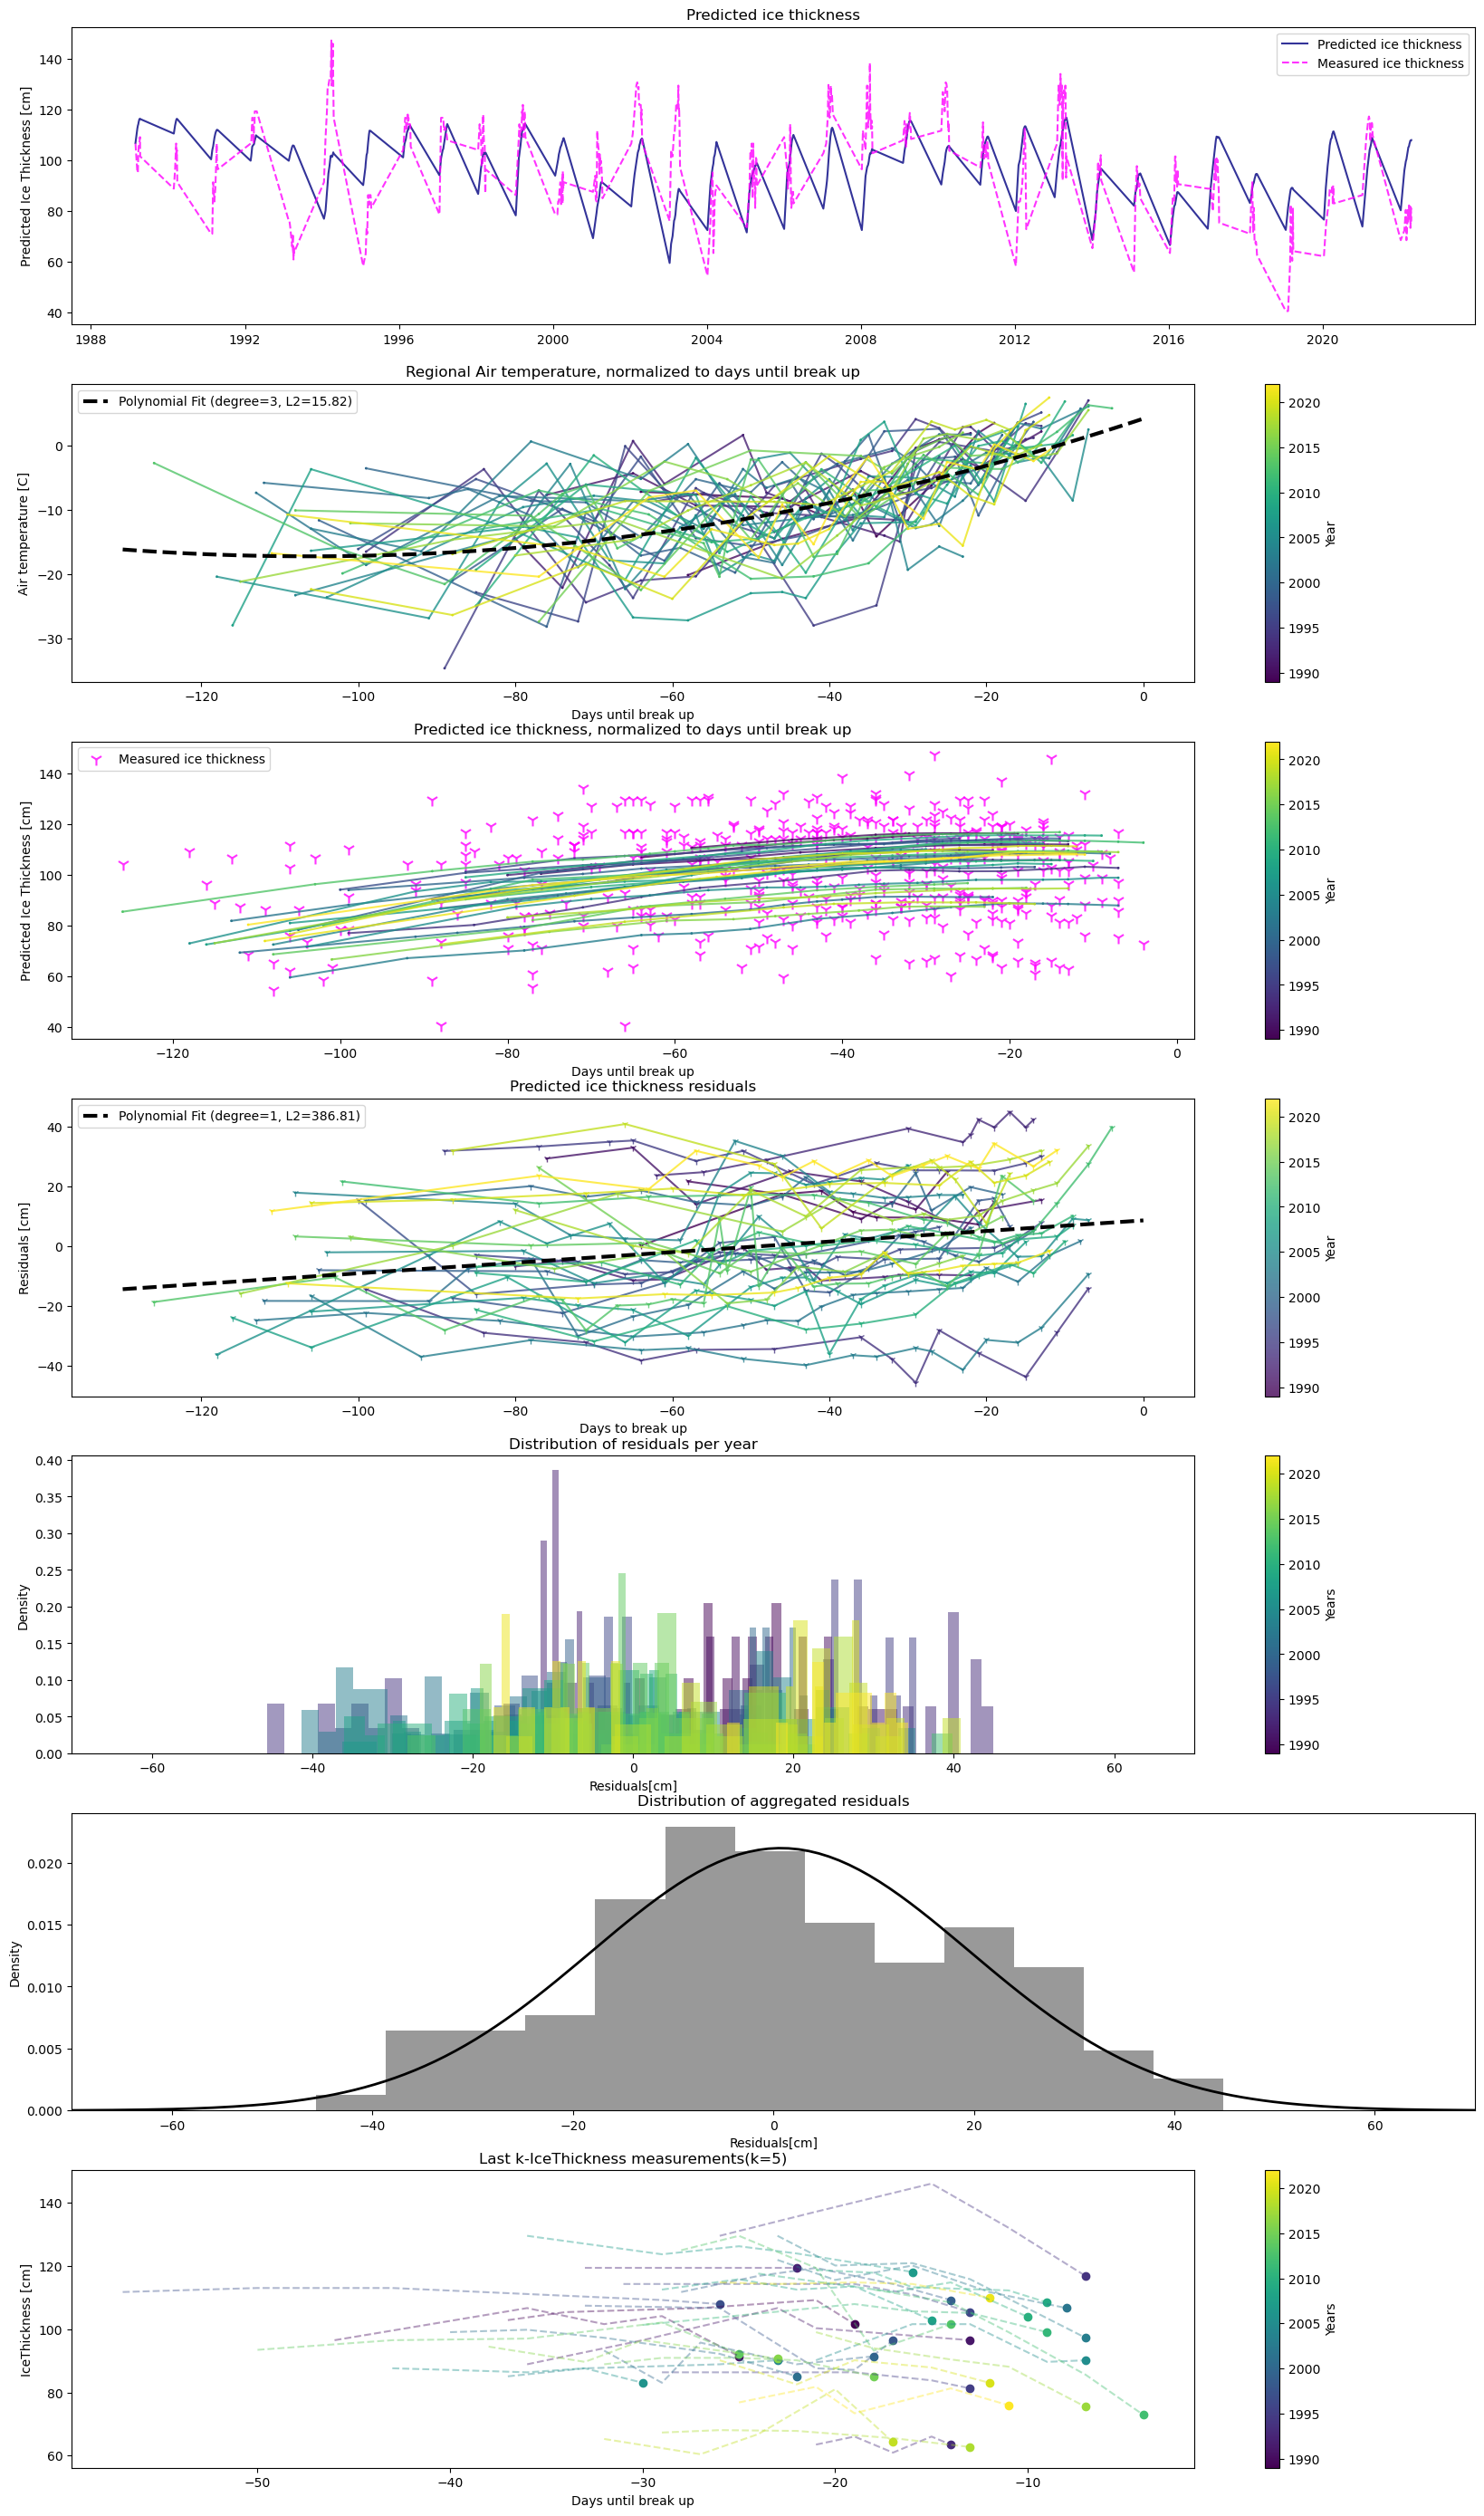

In [116]:
standard_plot(Data,Data['Predicted ice thickness [m]']*1.23)